In [1]:
import matplotlib.pyplot as plt
import hopsy
import os
import numpy as np
from scipy.optimize import fsolve
import pandas as pd
from scipy.optimize import curve_fit
from PolyRound.api import PolyRoundApi

In [2]:
class Boltzman_Modell:
    def __init__(self, beta, index):
        self.beta = beta
        self.index = index
        
    def compute_negative_log_likelihood(self, x):
        return - self.beta * x[self.index]

In [3]:
class Normal_Modell:
    def __init__(self, mu, sigma, index):
        self.mu = mu
        self.index = index
        self.sigma = sigma
        
    def compute_negative_log_likelihood(self, x):
        return 0.5 * (x[self.index]-self.mu)**2/(self.sigma**2)

In [4]:
model_path = os.path.join("C:/Users/carol/OneDrive/Desktop/Juelich", "e_coli_core.xml")

In [5]:
raw_polytope = PolyRoundApi.sbml_to_polytope(model_path)
biomass_index = raw_polytope.A.columns.tolist().index('BIOMASS_Ecoli_core_w_GAM')
glucose_uptake_index = raw_polytope.A.columns.tolist().index('EX_glc__D_e')
polytope = PolyRoundApi.simplify_transform_and_round(raw_polytope)

In [7]:
uniform = hopsy.Problem(A=polytope.A, b=polytope.b, transformation=polytope.transformation, shift=polytope.shift)
starting_point = hopsy.compute_chebyshev_center(uniform)

In [8]:
# Für die Boltzmann-Verteilung
a = np.array(0)
model_Boltzmann = Boltzman_Modell(a, glucose_uptake_index)
uniform_2 = hopsy.Problem(A=polytope.A, b=polytope.b, model = model_Boltzmann, transformation=polytope.transformation, shift=polytope.shift)
starting_point_2 = hopsy.compute_chebyshev_center(uniform_2)

In [9]:
# Für die Boltzmann-Verteilung
a = np.array(10)
model_Boltzmann = Boltzman_Modell(a, glucose_uptake_index)
boltzmann_1 = hopsy.Problem(A=polytope.A, b=polytope.b, model = model_Boltzmann, transformation=polytope.transformation, shift=polytope.shift)
starting_point_boltzmann = hopsy.compute_chebyshev_center(boltzmann_1)

In [10]:
# Für die Boltzmann-Verteilung
a = np.array(-10)
model_Boltzmann = Boltzman_Modell(a, glucose_uptake_index)
boltzmann_2 = hopsy.Problem(A=polytope.A, b=polytope.b, model = model_Boltzmann, transformation=polytope.transformation, shift=polytope.shift)
starting_point_boltzmann_2 = hopsy.compute_chebyshev_center(boltzmann_2)

In [11]:
# Für die Boltzmann-Verteilung
a = np.array(-100)
model_Boltzmann = Boltzman_Modell(a, glucose_uptake_index)
boltzmann_3 = hopsy.Problem(A=polytope.A, b=polytope.b, model = model_Boltzmann, transformation=polytope.transformation, shift=polytope.shift)
starting_point_boltzmann_3 = hopsy.compute_chebyshev_center(boltzmann_3)

In [12]:
# Für die Normal-Verteilung
mu = np.array(1)
sigma = np.array(50)
model_normal = Normal_Modell(mu, sigma, glucose_uptake_index)


In [13]:
normal = hopsy.Problem(A=polytope.A, b=polytope.b, model = model_normal, transformation=polytope.transformation, shift=polytope.shift)
starting_point_normal_3 = hopsy.compute_chebyshev_center(normal)

In [14]:
problems = {
    'uniform': [uniform, starting_point],
    'beta=0': [uniform_2, starting_point_2],  
    'beta=10': [boltzmann_1, starting_point_boltzmann], 
     'beta=-10': [boltzmann_2, starting_point_boltzmann_2], 
     'beta = -100': [boltzmann_3, starting_point_boltzmann_3],
     'normal':[normal, starting_point_normal_3]
    }

In [15]:
rhat = {}
ess = {}
samples = {}
acceptance_rate = {}
n_chains = 4 
n_samples = 10000
thinning = 10

for p, liste in problems.items():
    v = liste[0]
    s = liste[1]
    print(p)
    proposal = hopsy.UniformCoordinateHitAndRunProposal(v, starting_point=s)
    mcs = [hopsy.MarkovChain(problem=v, proposal=proposal) for i in range(n_chains)]
    rngs = [hopsy.RandomNumberGenerator(i) for i in range(n_chains)]
    acceptance_rate[p], samples[p] = hopsy.sample(mcs, rngs, n_samples=n_samples, thinning=thinning, n_procs=1)
    ess[p] = hopsy.ess(samples[p])
    print('\tess', np.min(ess[p]))
    rhat[p] = hopsy.rhat(samples[p])
    print('\trhat', np.max(rhat[p]))

uniform
	ess 730.2609014651691
	rhat 1.0066610470050092
beta=0
	ess 730.2609014651691
	rhat 1.0066610470050092
beta=10
	ess 26.086769019171392
	rhat 1.097144427560824
beta=-10
	ess 441.74557951205486
	rhat 1.0145519595419834
beta = -100
	ess 13.732520786651197
	rhat 1.2494040353132299
normal
	ess 707.7705494322031
	rhat 1.0060608485622042


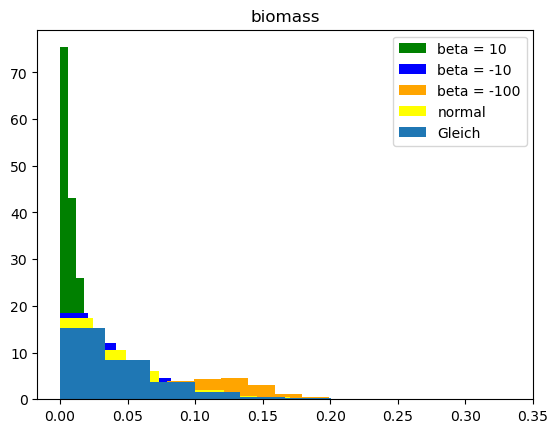

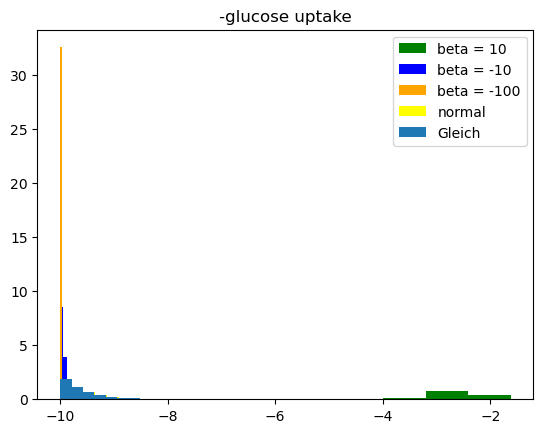

In [17]:
plt.title('biomass')
#plt.hist(samples['uniform'][0, :, biomass_index], density = True, label = "Gleich")
# TODO
#plt.hist(samples['beta=0'][0, :, biomass_index], density = True, color = "red",label = "beta = 0" )
plt.hist(samples['beta=10'][0, :, biomass_index], density = True, color = "green", label = "beta = 10")
plt.hist(samples['beta=-10'][0, :, biomass_index], density = True, color = "blue", label = "beta = -10")
plt.hist(samples['beta = -100'][0, :, biomass_index], density = True, color = "orange", label = "beta = -100")
plt.hist(samples['normal'][0, :, biomass_index], density = True, color = "yellow", label = "normal")
plt.hist(samples['uniform'][0, :, biomass_index], density = True, label = "Gleich")


plt.legend(loc='upper right')
plt.show()
plt.title('-glucose uptake')
#plt.hist(samples['beta=0'][0, :, glucose_uptake_index], density = True, color = "red",label = "beta = 0")
plt.hist(samples['beta=10'][0, :, glucose_uptake_index], density = True, color = "green", label = "beta = 10")
plt.hist(samples['beta=-10'][0, :, glucose_uptake_index], density = True, color = "blue", label = "beta = -10")
plt.hist(samples['beta = -100'][0, :, glucose_uptake_index], density = True, color = "orange", label = "beta = -100")
plt.hist(samples['normal'][0, :, glucose_uptake_index], density = True, color = "yellow", label = "normal")
plt.hist(samples['uniform'][0, :, glucose_uptake_index], density = True, label = "Gleich")

plt.legend(loc='upper right')
plt.show()

In [36]:
help(hopsy.MarkovChain)

Help on function MarkovChain in module hopsy.misc:

MarkovChain(problem: hopsy.core.Problem, proposal: Union[hopsy.core.Proposal, Type[hopsy.core.Proposal]] = <class 'hopsy.core.GaussianHitAndRunProposal'>, starting_point: Union[numpy.__array_like._SupportsArray[numpy.dtype], numpy.__nested_sequence._NestedSequence[numpy.__array_like._SupportsArray[numpy.dtype]], bool, int, float, complex, str, bytes, numpy.__nested_sequence._NestedSequence[Union[bool, int, float, complex, str, bytes]]] = None, parallelTemperingSyncRng: hopsy.core.RandomNumberGenerator = None, exchangeAttemptProbability: float = 0.1)
    MarkovChain(problem, proposal=hopsy.GaussianHitAndRun, starting_point=None)
    
    Given a hopsy.Problem a MarkovChain object can be constructed. The Markov chain keeps track of the internal state and the selected proposal mechanism, see proposal argument.
    Several Markov chain objects can be sampled in parallel by passing them as a list to hopsy.sample.

